In [2]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.special import sph_harm
from scipy.integrate import quad, dblquad

import numpy as np
import trimesh as tri
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

import sys
import os
import six

sys.path.insert(0,"../")
import pyssht

from utils import brownian_motion, sph_utils, mesh_processing

Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


In [3]:
N = 64
n = 25
sphere = tri.creation.uv_sphere(count=[N, N])
x, y ,z = np.array(sphere.vertices[:,0]), np.array(sphere.vertices[:,1]), np.array(sphere.vertices[:,2])
(r, theta, phi) = pyssht.cart_to_spherical(x, y, z)
my_basis = sph_utils.SphHarmBasis(n_coeffs=n)

listpq = []

def sphere_function_r_start(theta, phi):
    return np.array([1.0 for t in range(np.array(theta).size)])

def sphere_function_theta_start(theta, phi):
    return theta

def sphere_function_phi_start(theta, phi):
    return phi

def sphere_function_r_end(theta, phi):
    return np.array([2.0 for t in range(np.array(theta).size)])
    
def sphere_function_theta_end(theta, phi):
    return theta

def sphere_function_phi_end(theta, phi):
    return phi

In [4]:
coeffs_r_source = my_basis.sph_harm_transform(sphere_function_r_start)
coeffs_theta_source = my_basis.sph_harm_transform(sphere_function_theta_start)
coeffs_phi_source = my_basis.sph_harm_transform(sphere_function_phi_start)

coeffs_r_target = my_basis.sph_harm_transform(sphere_function_r_end)
coeffs_theta_target = my_basis.sph_harm_transform(sphere_function_theta_end)
coeffs_phi_target = my_basis.sph_harm_transform(sphere_function_phi_end)

In [5]:
reconstr_function_r_source = my_basis.sph_harm_reconstruct(coeffs_r_source)
reconstr_function_theta_source = my_basis.sph_harm_reconstruct(coeffs_theta_source)
reconstr_function_phi_source = my_basis.sph_harm_reconstruct(coeffs_phi_source)

f_recons_r_source = reconstr_function_r_source(theta,phi)
f_recons_theta_source = reconstr_function_theta_source(theta,phi)
f_recons_phi_source = reconstr_function_phi_source(theta,phi)

reconstr_function_r_target = my_basis.sph_harm_reconstruct(coeffs_r_target)
reconstr_function_theta_target = my_basis.sph_harm_reconstruct(coeffs_theta_target)
reconstr_function_phi_target = my_basis.sph_harm_reconstruct(coeffs_phi_target)

f_recons_r_target = reconstr_function_r_target(theta,phi)
f_recons_theta_target = reconstr_function_theta_target(theta,phi)
f_recons_phi_target = reconstr_function_phi_target(theta,phi)

(x_coord_source, y_coord_source, z_coord_source) = pyssht.spherical_to_cart(f_recons_r_source, 
                                                                            f_recons_theta_source, f_recons_phi_source)

(x_coord_target, y_coord_target, z_coord_target) = pyssht.spherical_to_cart(f_recons_r_target, 
                                                                            f_recons_theta_target, f_recons_phi_target)

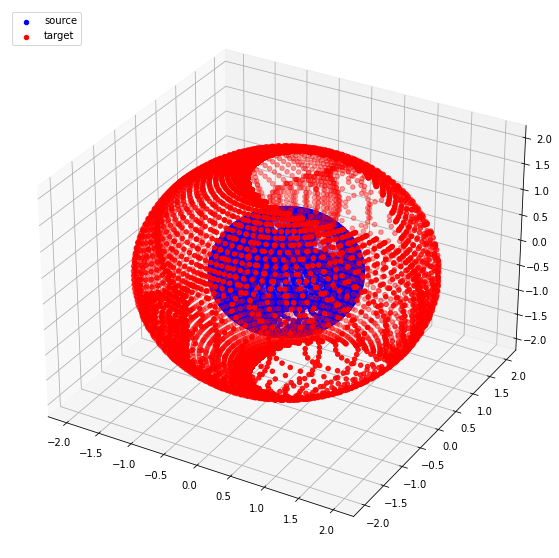

In [6]:
fig = plt.figure(figsize=(10,10))
ax1 = fig.add_subplot(111, projection='3d')
ax1.scatter(x_coord_source, y_coord_source, z_coord_source, c='b', label='source')
ax1.scatter(x_coord_target, y_coord_target, z_coord_target, c='r', label='target')

ax1.legend(loc = 'upper left')
plt.show()

In [16]:
t = 1

test = my_basis.sph_harm_reconstruct_bridge(coeffs_r_source, coeffs_r_target,
                                                           t = t, theta = theta, phi = phi, n_step = 100, eta = 0.5)
reconstr_function_r = test[0]
reconstr_function_theta = my_basis.sph_harm_reconstruct_bridge(coeffs_theta_source, coeffs_theta_target,
                                                               t = t, theta = theta, phi = phi, n_step = 100, eta = 0.5)[0]
reconstr_function_phi = my_basis.sph_harm_reconstruct_bridge(coeffs_phi_source, coeffs_phi_target,
                                                             t = t, theta = theta, phi = phi, n_step=100, eta = 0.5)[0]

### Remark !

Text(0.5, 1.0, 'Func')

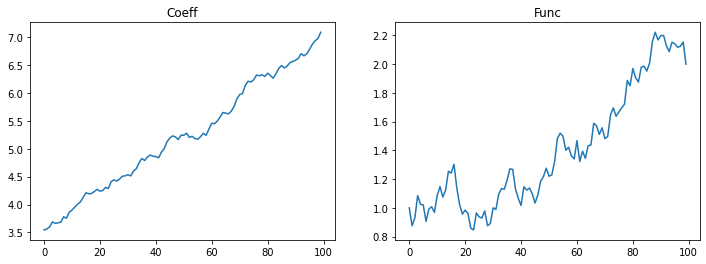

In [17]:
plt.figure(figsize=(12,4))
plt.subplot(1,2,1)
plt.plot(test[1][0])
plt.title("Coeff")

plt.subplot(1,2,2)
plt.plot(reconstr_function_r[:,0])
plt.title("Func")

The bridge on the coefficients does not descend as smoothly on the function: it depends on the basis !

### Visuals

In [18]:
listpq = []
for t in range(reconstr_function_r.shape[0]):
    (x_coord_stoch, y_coord_stoch, z_coord_stoch) = pyssht.spherical_to_cart(reconstr_function_r[t], 
                                                                             reconstr_function_theta[t], 
                                                                             reconstr_function_phi[t])
    listpq.append([x_coord_stoch, y_coord_stoch, z_coord_stoch])
        
listpq = np.array(listpq)

#setting up the faces for the mesh
rows_unique = np.unique(listpq[0,:,:].T, axis=0, return_index=True)
new = listpq[0,:,:].T[rows_unique[1]]
hull = tri.convex.convex_hull(new, qhull_options='QbB Pp Qt QJ')
faces = hull.faces

In [19]:
listpq.shape

(100, 3, 8128)

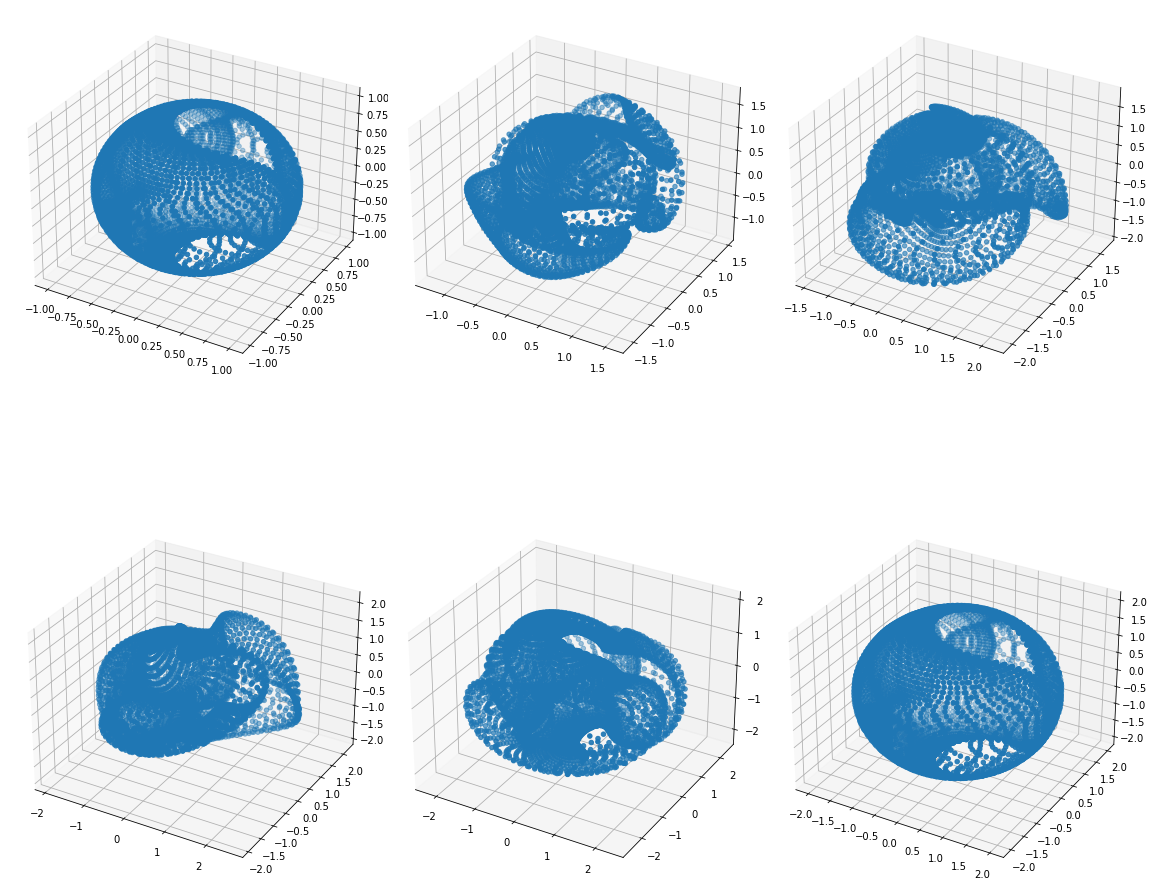

In [20]:
fig = plt.figure(figsize=(16,16))

ax1 = fig.add_subplot(231, projection='3d')
ax1.scatter(listpq[0,:,:].T[rows_unique[1]][:,0], listpq[0,:,:].T[rows_unique[1]][:,1], listpq[0,:,:].T[rows_unique[1]][:,2])

ax2 = fig.add_subplot(232, projection='3d')
ax2.scatter(listpq[20,:,:].T[rows_unique[1]][:,0], listpq[20,:,:].T[rows_unique[1]][:,1], listpq[20,:,:].T[rows_unique[1]][:,2])

ax3 = fig.add_subplot(233, projection='3d')
ax3.scatter(listpq[40,:,:].T[rows_unique[1]][:,0], listpq[40,:,:].T[rows_unique[1]][:,1], listpq[40,:,:].T[rows_unique[1]][:,2])

ax4 = fig.add_subplot(234, projection='3d')
ax4.scatter(listpq[60,:,:].T[rows_unique[1]][:,0], listpq[60,:,:].T[rows_unique[1]][:,1], listpq[60,:,:].T[rows_unique[1]][:,2])

ax5 = fig.add_subplot(235, projection='3d')
ax5.scatter(listpq[80,:,:].T[rows_unique[1]][:,0], listpq[80,:,:].T[rows_unique[1]][:,1], listpq[80,:,:].T[rows_unique[1]][:,2])

ax6 = fig.add_subplot(236, projection='3d')
ax6.scatter(listpq[-1,:,:].T[rows_unique[1]][:,0], listpq[-1,:,:].T[rows_unique[1]][:,1], listpq[-1,:,:].T[rows_unique[1]][:,2])

plt.tight_layout()
plt.show()

### mesh .gif export

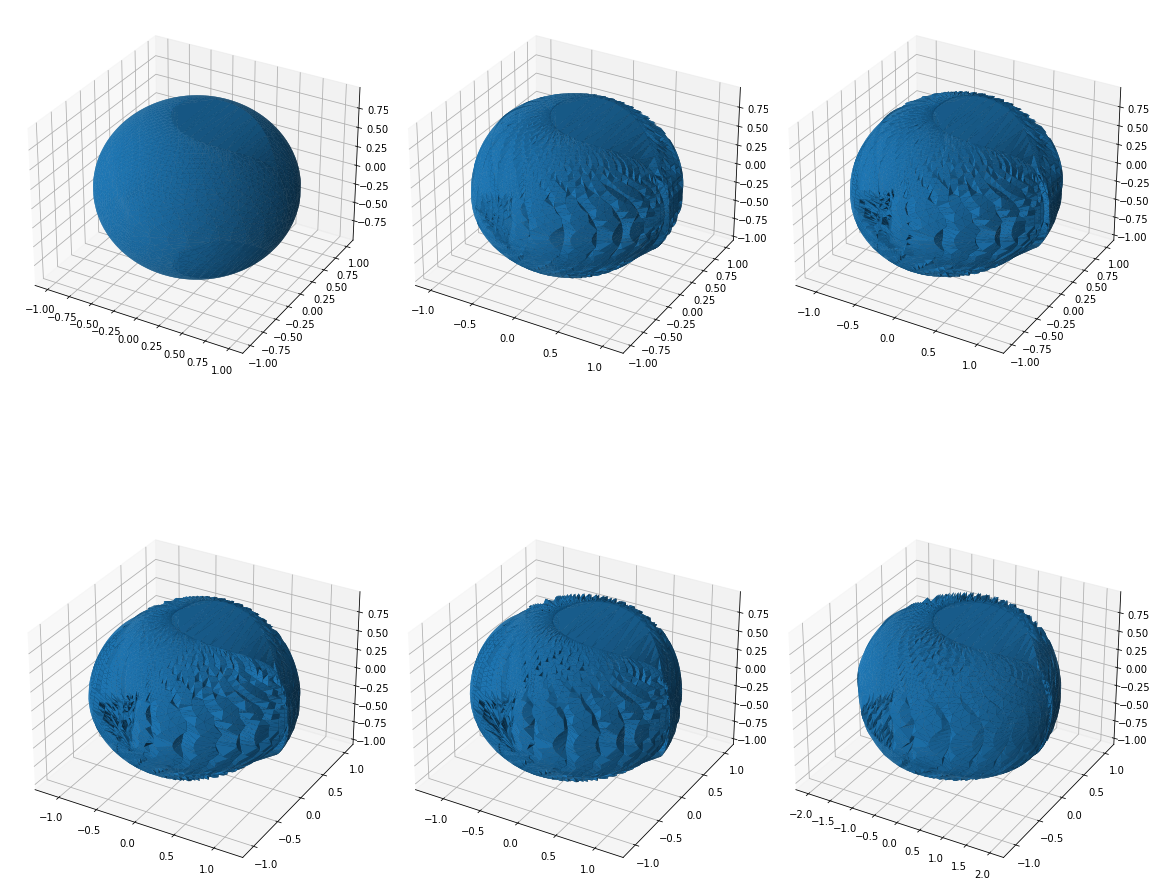

In [12]:
fig = plt.figure(figsize=(16,16))

ax1 = fig.add_subplot(231, projection='3d')
ax1.plot_trisurf(listpq[0,:,:].T[rows_unique[1]][:,0], listpq[0,:,:].T[rows_unique[1]][:,1], triangles=faces, Z=listpq[0,:,:].T[rows_unique[1]][:,2])

ax2 = fig.add_subplot(232, projection='3d')
ax2.plot_trisurf(listpq[4,:,:].T[rows_unique[1]][:,0], listpq[1,:,:].T[rows_unique[1]][:,1], triangles=faces, Z=listpq[1,:,:].T[rows_unique[1]][:,2])

ax3 = fig.add_subplot(233, projection='3d')
ax3.plot_trisurf(listpq[8,:,:].T[rows_unique[1]][:,0], listpq[2,:,:].T[rows_unique[1]][:,1], triangles=faces, Z=listpq[2,:,:].T[rows_unique[1]][:,2])

ax4 = fig.add_subplot(234, projection='3d')
ax4.plot_trisurf(listpq[12,:,:].T[rows_unique[1]][:,0], listpq[3,:,:].T[rows_unique[1]][:,1], triangles=faces, Z=listpq[3,:,:].T[rows_unique[1]][:,2])

ax5 = fig.add_subplot(235, projection='3d')
ax5.plot_trisurf(listpq[16,:,:].T[rows_unique[1]][:,0], listpq[4,:,:].T[rows_unique[1]][:,1], triangles=faces, Z=listpq[4,:,:].T[rows_unique[1]][:,2])

ax6 = fig.add_subplot(236, projection='3d')
ax6.plot_trisurf(listpq[-1,:,:].T[rows_unique[1]][:,0], listpq[5,:,:].T[rows_unique[1]][:,1], triangles=faces, Z=listpq[5,:,:].T[rows_unique[1]][:,2])

plt.tight_layout()
plt.show()

In [13]:
mesh_processing.create_gif(listpq, "test.gif")